In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import RigidTransform, StartMeshcat, MeshcatVisualizer

from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.perception import Concatenate
from pydrake.systems.framework import DiagramBuilder

from manipulation.scenarios import AddRgbdSensors
from manipulation.utils import ConfigureParser


In [4]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [202]:
def BallExampleSystem():
    builder = DiagramBuilder()

    # Create the physics engine + scene graph.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.package_map().AddPackageXml(filename="./package.xml")
    parser.AddModelsFromUrl("package://bot_shot/models/training.dmd.yaml")
    plant.Finalize()

    # Add a visualizer just to help us see the object.
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
        # meshcat = builder.AddSystem(MeshcatVisualizer(scene_graph))
        # builder.Connect(
        #     scene_graph.get_query_output_port(),
        #     meshcat.get_geometry_query_input_port(),
        # )

    AddRgbdSensors(builder, plant, scene_graph)

    diagram = builder.Build()
    diagram.set_name("depth_camera_demo_system")
    return diagram

In [265]:
class SimpleCameraSystem:
    def __init__(self):
        diagram = BallExampleSystem()
        context = diagram.CreateDefaultContext()

        # setup
        meshcat.SetProperty("/Background", "visible", False)

        # getting data
        self.point_cloud = diagram.GetOutputPort("camera0_point_cloud").Eval(context)
        self.depth_im_read = (
            diagram.GetOutputPort("camera0_depth_image").Eval(context).data.squeeze()
        )
        self.depth_im = deepcopy(self.depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        label_im = (
            diagram.GetOutputPort("camera0_label_image").Eval(context).data.squeeze()
        )
        self.rgb_im = diagram.GetOutputPort("camera0_rgb_image").Eval(context).data
        self.mask = label_im == 1

        # draw visualization
        meshcat.SetObject("point_cloud", self.point_cloud)
        diagram.ForcedPublish(context)

        # camera specs
        cam0 = diagram.GetSubsystemByName("camera0")
        cam0_context = cam0.GetMyMutableContextFromRoot(context)
        self.X_WC = cam0.GetOutputPort("body_pose_in_world").Eval(cam0_context)
        self.X_WC = RigidTransform(self.X_WC)  # See drake issue #15973
        self.cam_info = cam0.default_depth_render_camera().core().intrinsics()

        # get points for mustard bottle
        depth_mustard = self.mask * self.depth_im
        u_range = np.arange(depth_mustard.shape[0])
        v_range = np.arange(depth_mustard.shape[1])
        depth_v, depth_u = np.meshgrid(v_range, u_range)
        depth_pnts = np.dstack([depth_u, depth_v, depth_mustard])
        depth_pnts = depth_pnts.reshape([depth_pnts.shape[0] * depth_pnts.shape[1], 3])
        pC = self.project_depth_to_pC(depth_pnts)
        p_C_mustard = pC[pC[:, 2] > 0]
        self.p_W_mustard = self.X_WC.multiply(p_C_mustard.T).T

    def get_color_image(self):
        return deepcopy(self.rgb_im[:, :, 0:3])

    def get_intrinsics(self):
        # read camera intrinsics
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        return cx, cy, fx, fy

    def project_depth_to_pC(self, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx, cy, fx, fy = self.get_intrinsics()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC


def bbox(img):
    a = np.where(img != 0)
    bbox = ([np.min(a[0]), np.max(a[0])], [np.min(a[1]), np.max(a[1])])
    return bbox

meshcat.Delete()
env = SimpleCameraSystem()
X_WC = env.X_WC
p_W_mustard = env.p_W_mustard
K = env.cam_info.intrinsic_matrix()
rgb_im = env.get_color_image()

In [242]:
def deproject_pW_to_image(p_W_mustard, cx, cy, fx, fy, X_WC):
    """
    convert points in the world frame to camera pixels
    Input:
        - p_W_mustard: points of the mustard bottle in world frame (nx3)
        - fx, fy, cx, cy: camera intrinsics
        - X_WC: camera pose in the world frame
    Output:
        - mask: numpy array of size 480x640
    """
    # Transfer bottle to camera frame
    p_C_mustard = X_WC.inverse().multiply(p_W_mustard.T).T
    X_c = p_C_mustard[:, 0]
    Y_c = p_C_mustard[:, 1]
    Z_c = p_C_mustard[:, 2]

    # Deproject onto image plane
    u = (X_c / Z_c) * fx + cx
    v = (Y_c / Z_c) * fy + cy

    # Convert to integer pixel coordinates
    u = np.round(u).astype(int)
    v = np.round(v).astype(int)

    # Create an empty mask
    depth_image_shape = [480, 640]
    mask = np.zeros(depth_image_shape, dtype=np.uint8)
    
    # Filter points that lie within image boundaries
    valid_indices = (u >= 0) & (u < depth_image_shape[1]) & (v >= 0) & (v < depth_image_shape[0])
    u = u[valid_indices]
    v = v[valid_indices]
    
    # Set mask pixels corresponding to the mustard bottle to 1
    mask[v, u] = 1
    
    return mask

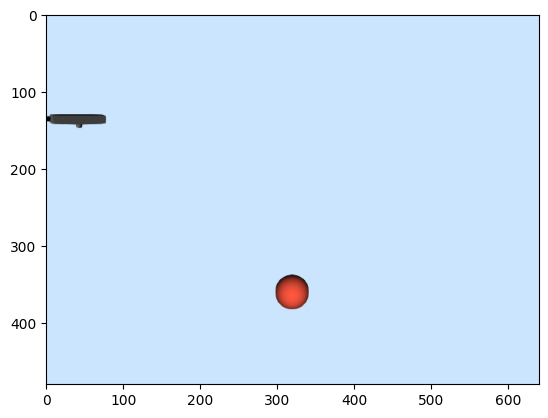

In [269]:
plt.imshow(rgb_im)

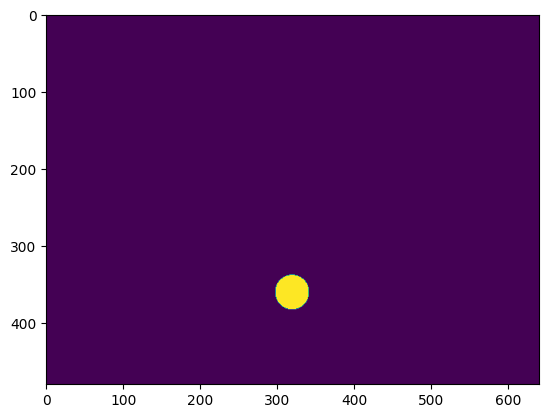

In [270]:
cx, cy, fx, fy = env.get_intrinsics()
mask = deproject_pW_to_image(p_W_mustard, cx, cy, fx, fy, X_WC)
plt.imshow(mask)

In [ ]:
! pip3 install keras
! pip3 install tensorflow

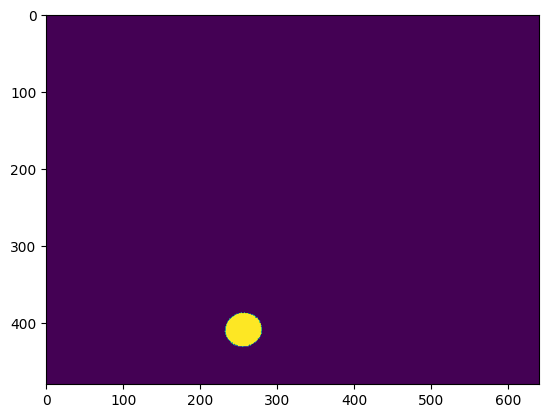

In [273]:
# Importing necessary functions
import os
from PIL import Image
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
  
# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
        rotation_range = 180,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))
   
# Loading a sample image 
img = np.concatenate([rgb_im, np.reshape(mask, [480, 640, 1])], axis=2)

# Converting the input sample image to an array
x = img_to_array(img)
  
# Generating and saving 5 augmented samples 
# using the above defined parameters. 
num_of_training = 119
save_to_dir = "./ball_training"
for i in range(num_of_training):
    transformed = datagen.random_transform(x)
    rgb_new = transformed[:, :, :3]
    mask_new = transformed[:, :, 3]
    base = 10179
    label = {"2": "012_ball"}
    img = Image.fromarray(rgb_new.astype('uint8'))
    img.save(os.path.join(save_to_dir, f"{base + i}.png"))
    np.save(os.path.join(save_to_dir, f"{base + i}_mask.npy"), mask_new)
    with open(os.path.join(save_to_dir, f"{base + i}.json"), "w") as outfile:
        json.dump(label, outfile) 

plt.imshow(mask_new)


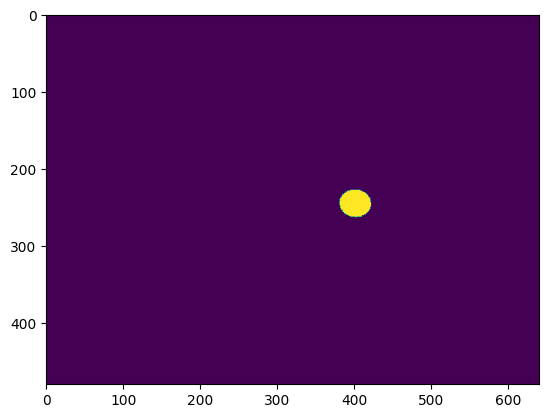

In [272]:
plt.imshow(np.squeeze(np.load(os.path.join(save_to_dir, f"{base + 117}_mask.npy"))))